# Adversarial Attack on Deep Networks
In this question, we will implement fast gradient sign attack (FGSM) on a pre-trained convolution network with very high accuracy on the MNIST dataset. This reveals the striking lack of robustness present in deep networks. FGSM was first introduced by Goodfellow et al. in 2014. Check out their paper: [Explaining and harnessing adversarial examples](https://arxiv.org/pdf/1412.6572.pdf).

In [1]:
import logging
import numpy as np
import tensorflow as tf
#from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Step 1: Read in data


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
datadir='MNIST_data'
mnist = input_data.read_data_sets(datadir, one_hot=True, reshape=False)

#get MNIST test set
X_test = mnist.test.images
Y_test = mnist.test.labels


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
Y_test.shape #confirm Y is in one-hot format

(10000, 10)

# Step 2: Load model
Loading a pre-learned model in tensorflow is simple. We need to first load the meta data which is the computation graph. Then, load the weights. Why do we need `tf.Session()` to load a model? Remember that the model variables have no value without the session!

In [4]:
sess = tf.Session()
# load the computation graph
saver = tf.train.import_meta_graph('MNIST_model/model_Q3.meta')
# load the weights
saver.restore(sess, 'MNIST_model/model_Q3')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from MNIST_model/model_Q3


# Step 2.1 (optional): Visualize the model with Tensorboard
[Tensorboard](https://www.tensorflow.org/get_started/summaries_and_tensorboard) is a visualization tool that comes with tensorflow. Here, we use it to visualize the model that you just loaded.

To start tensorboard, 

- Open a Terminal and navigate to the root directory of the assignment. 
- Type `tensorboard --logdir=MNIST_model/`. The server will be launched in the terminal and a url will be displayed.
- Open the url in a browser and click the Graph tab. You should see the model that you just loaded. How many convolution layers does it have?

# Step 2.5: Get tensors from the model

In [5]:
#load the variables from the pre-trained model so we can use them
graph = tf.get_default_graph()
x = graph.get_tensor_by_name('x:0')
y = graph.get_tensor_by_name('y:0')
logits = graph.get_tensor_by_name('fc_1/logits:0')
probs = graph.get_tensor_by_name('probs:0')
cross_entropy = graph.get_tensor_by_name('cross_entropy:0')
accuracy = graph.get_tensor_by_name('accuracy:0')
preds_label = graph.get_tensor_by_name('preds_label:0')

In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
# sanity check: the test accuracy for this model should be over .99
print('test accuracy {}'.format(sess.run(accuracy, feed_dict={
    x: X_test, y: Y_test})))

test accuracy 0.9905999898910522


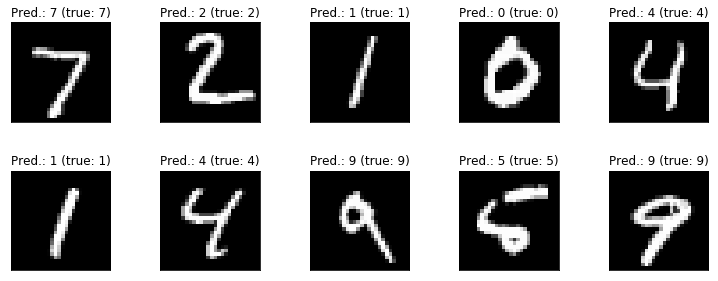

In [8]:
# Plot the first 10 images in the test set on a 2-by-5 grid of subplots, together with their
# true labels and the ones predicted by the pre-trained network.

preds,logits_ = sess.run([preds_label, logits], feed_dict={x: X_test, y: Y_test})

nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*2.5,nrows*2.5)) #get a new fig and subplot axes
fig.subplots_adjust(wspace=.5) #adjust horizontal spacing between subplots

for row in range(nrows):
    for col in range(ncols):
        ax = axes[row,col] #get the axis for the current subplot
        img_index = row*ncols + col
        img = X_test[img_index].squeeze() #squeeze: get rid of img's third dimension, since grayscale
        true_label = Y_test[img_index].argmax() #argmax: convert from one-hot into class label
        pred_label = preds[img_index]
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.set_title('Pred.: {} (true: {})'.format(pred_label, true_label))
        ax.set_xticks([]); ax.set_yticks([])


# Step 3: Get the output label for the raw image.

In [9]:
#we need the model predictions in one-hot format
logit_max = tf.reduce_max(logits, axis=1, keepdims=True) #max val of each logit vector
model_predict = tf.to_float(tf.equal(logits, logit_max)) #convert probs into 0s or 1s

Instructions for updating:
Use tf.cast instead.


# Step 4: calculate the cross entropy loss 
Use `model_predict` as your y labels.

HINT: This time, do not use `tf.reduce_mean`. Why?

In [10]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=model_predict)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Step 5: Gradient of the loss w.r.t. x
The loss function is a function of the input image x. 
We want to calculate the gradient of the loss with respect to x.

HINT: use `tf.gradients`

In [11]:
grad = tf.gradients(loss, x)[0] #take the first entry in the list (corresp. to first and only image)

In [12]:
grad.shape #check the dimensions: we have one grad val for each pixel

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

# Step 6: Get the sign of the gradient
We are using a very simple strategy for the noise, which is a fixed scalar with the same sign as the gradient. When we add it to the images, this amounts to doing gradient __ascent__ on the loss!

In [13]:
grad_sign = tf.sign(grad)

# Step 7: Rescale grad_sign

In [14]:
eps = 0.3 #scale it so the change to x is small
scaled_grad = eps * grad_sign

# Step 8: Perturb the raw image

Add `scaled_grad` to `x` and let the result be `adv_x` (`adv_x` is the adversarial image).

In [15]:
# TODO
adv_x = scaled_grad + x

# Step 9: Clip adv_x
Clip the value of `adv_x` so that the values are between 0 and 1 (this guarantees the pixels are within the 0-1 range needed for an image).

HINT: use `tf.clip_by_value`

In [16]:
# TODO
adv_x = tf.clip_by_value(adv_x,0,1)
print(adv_x)

Tensor("clip_by_value:0", shape=(?, 28, 28, 1), dtype=float32)


# Step 10: Generate adversarial images 
Store them as `adv_x_images`.

In [18]:
adv_images = None
nBatches = 10
for idx in range(nBatches):
    print(idx,end=' ')
    #take 1000 images at a time to do this in batches
    first, last = 1000 * idx, 1000 * (idx + 1)
    
    adv_images_batch = sess.run(adv_x, feed_dict={
        x: X_test[first:last, ...], y: Y_test[first:last]})
    
    if adv_images is not None:
        adv_images = np.concatenate([adv_images, adv_images_batch], axis=0)#append current batch to total output
    else:
        adv_images = adv_images_batch
        

0 1 2 3 4 5 6 7 8 9 

# Step 11: Accuracy on adversarial images
Now check the accuracy on the modified test images. You should expect to see the accuracy drop dramatically to around 0.11!

In [19]:
print(sess.run(accuracy, feed_dict={x: adv_images, y: Y_test}))

0.1147


# Step 12: Display sample adversarial images
Maybe the reason for such a low accuracy is that the modified test images are unrecognizable after the process? Display a few of them so you can check for yourself...

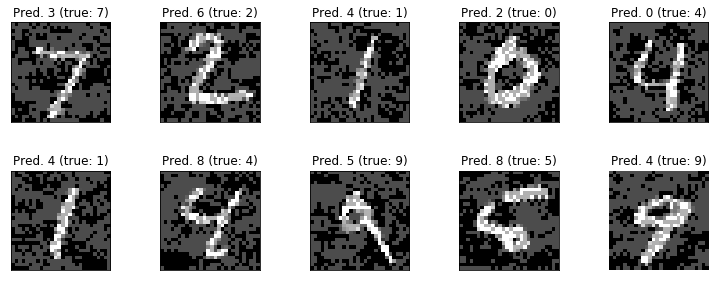

In [20]:
#get the classification label (digit) given to the adversarial image
label_hat = sess.run(tf.argmax(probs, axis=1), feed_dict={x: adv_images, y: Y_test})

#show first 10 images in a 2-by-5 grid of subplots

nrows = 2
ncols = 5
fig, axes = plt.subplots(2,5,figsize=(ncols*2.5,nrows*2.5)) #get a new fig and subplot axes
fig.subplots_adjust(wspace=.5)  
plt.axis('off')
for row in range(nrows):
    for col in range(ncols):
        ax = axes[row,col]#get the axis for the current subplot
        img_index = row*ncols + col
        img = adv_images[img_index].squeeze()
        true_label = Y_test[img_index].argmax()
        pred_label = label_hat[img_index]
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.set_title('Pred. {} (true: {})'.format(pred_label, true_label))
        ax.set_xticks([]); ax.set_yticks([])


So, are the digits really unrecognizable after the attack? Or do they pretty much look the same to you?
Can you explain why is it that a network with such high accuracy on this dataset could be fooled
by this simple noise?


The digits are not that unrecognizable. Adding the noise does not prevent me from recognizing the data correctly and they are pretty much the same. 

Some possible explanations: (a) such an accurate network was greatly overfitted and adding noise increases this effect. (b) a neural network with at least one hidden layer can represent any function to an arbitary degree of accuracy so long as its hidden layer is permitted to have enough units. Shallow linear models are not able to become constant near training points while also assigning different outputs to different training points. (c) individual models have strange quirks but averaging over many models can cause adversarial examples to wash out